# HOMEWORK 4

In this assignment, a lane detection pipeline is developed. Lane detection is essential for ADAS systems and plays a key role in Lane Keep Assist (LKA) functionality.
Based on an image acquired from a front-facing vehicle camera, the following processing stages are carried out:
- Grayscale conversion
- Edge detection
- Line detection using the Hough Transform

In [193]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

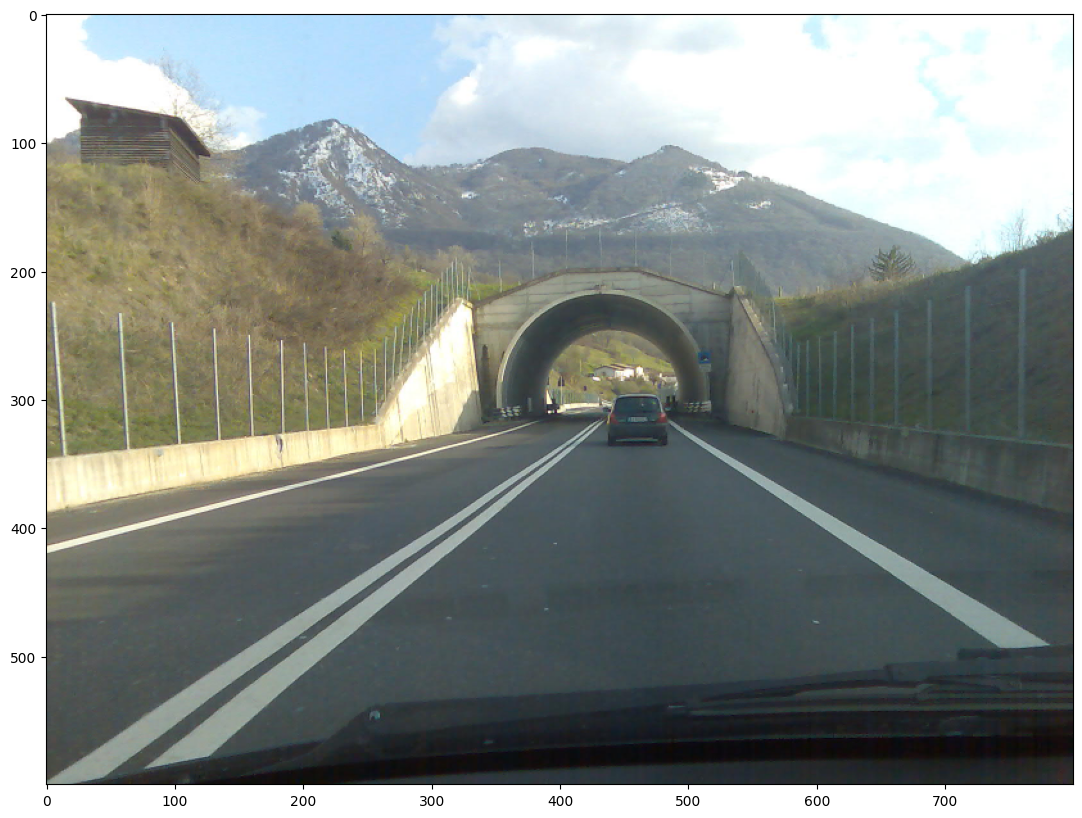

In [194]:
img = cv2.imread('data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

In [196]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [ ]:
edges =cv2.Canny(gray, 100, 150)
edges[0:350] = 0

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

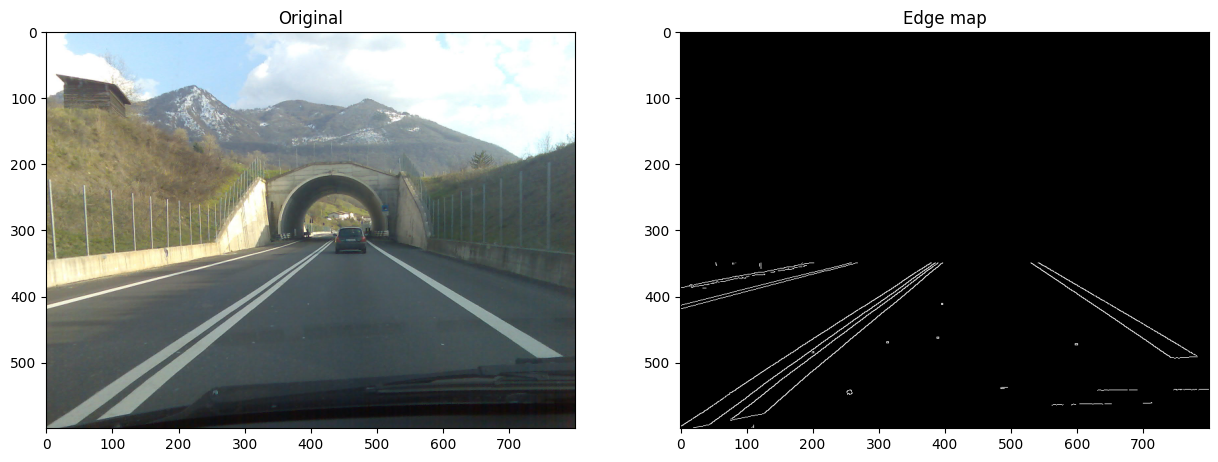

In [198]:
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [199]:
lines = cv2.HoughLines(edges, 2, np.pi/90, 190) 

lines = lines[:, 0, :]

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

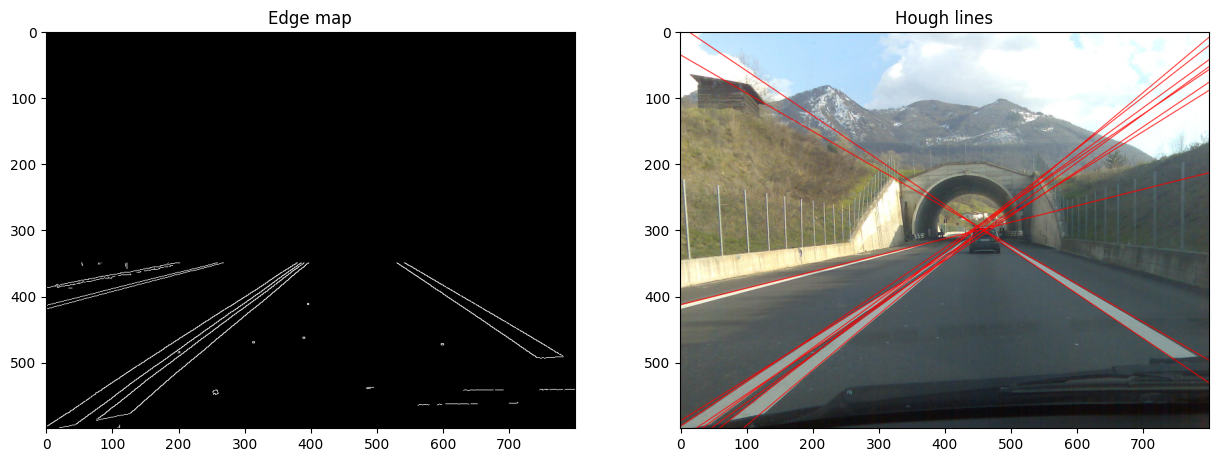

In [200]:
result = np.copy(img)
        
for line in lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [201]:
# Filter out lines whose theta lies between 70° and 110° (within 90° ± 20°)
filtered_lines = []
for line in lines:
    theta = line[1]
    if abs(theta - np.pi/2) > np.deg2rad(20): 
        filtered_lines.append(line)

In [202]:
for line in filtered_lines:
    rho = line[0]
    theta = line[1]
    deg = np.rad2deg(theta)

    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))

    print(f"Theta: {deg:.2f}°, pt1: {pt1}, pt2: {pt2}")

    cv2.line(result, pt1, pt2, (255, 0, 0), 2)


Theta: 50.00°, pt1: (-431, 1041), pt2: (1100, -243)
Theta: 54.00°, pt1: (-512, 996), pt2: (1105, -179)
Theta: 52.00°, pt1: (-474, 1016), pt2: (1101, -214)
Theta: 56.00°, pt1: (-552, 969), pt2: (1105, -148)
Theta: 124.00°, pt1: (-825, -564), pt2: (832, 553)
Theta: 54.00°, pt1: (-507, 1002), pt2: (1110, -172)
Theta: 58.00°, pt1: (-583, 953), pt2: (1112, -106)
Theta: 120.00°, pt1: (-881, -473), pt2: (850, 526)
Theta: 56.00°, pt1: (-543, 982), pt2: (1114, -135)


(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

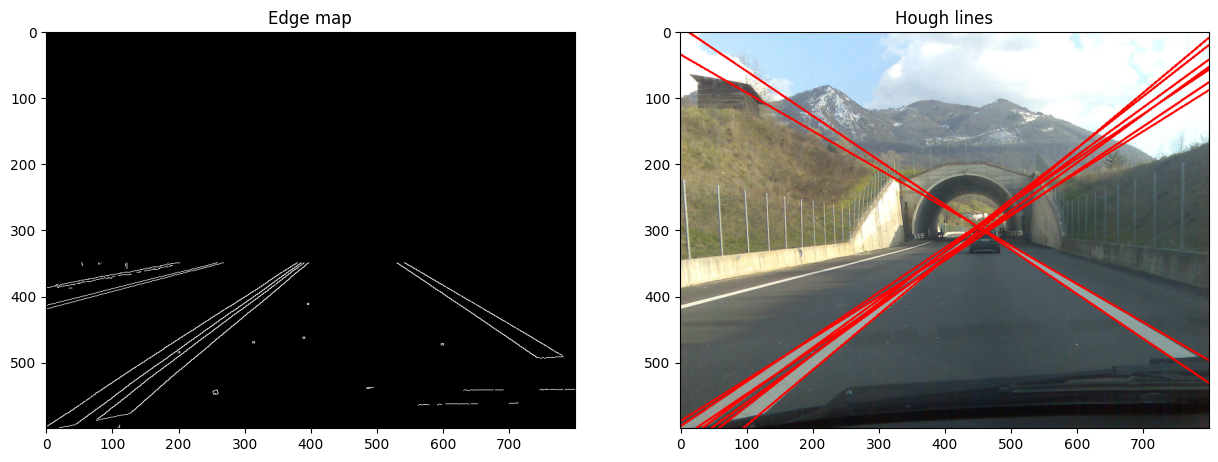

In [ ]:
result = np.copy(img)

h, w, _ = result.shape
roi = (0, 0, w, h)
 
for line in filtered_lines:
    rho = line[0]
    theta = line[1]

    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    ok, pt1c, pt2c = cv2.clipLine(roi, pt1, pt2)
    if ok:
        cv2.line(result, pt1c, pt2c, (255, 0, 0), 2)


plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [204]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

array([[507.        ,   0.92502448],
       [ -7.        ,   2.16420817],
       [ 31.        ,   2.09439516],
       [497.        ,   0.99483767],
       [521.        ,   0.87266463],
       [512.        ,   0.95993108]])

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

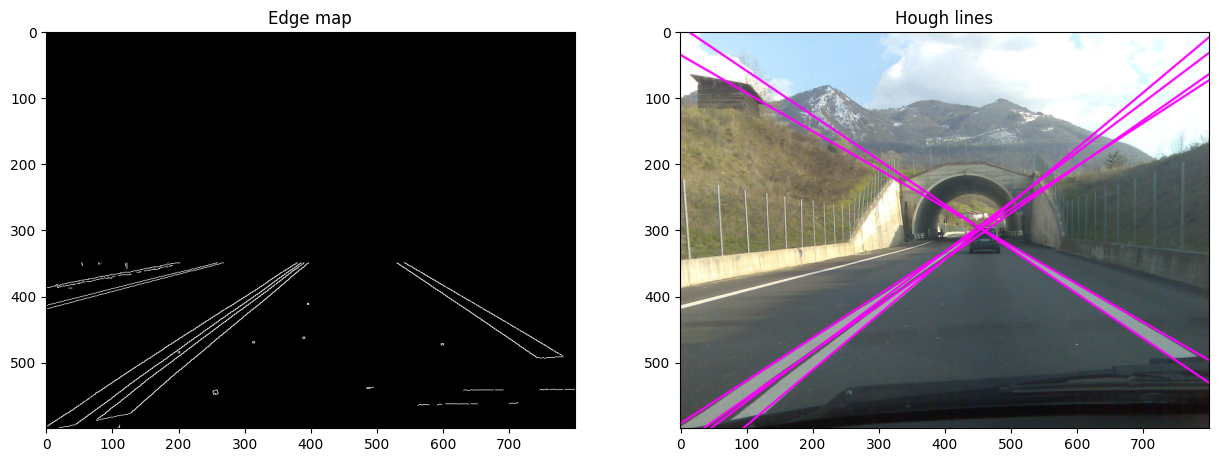

In [205]:
result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    cv2.line(result, pt1, pt2, (255, 0, 255), 2, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result), plt.title('Hough lines')

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

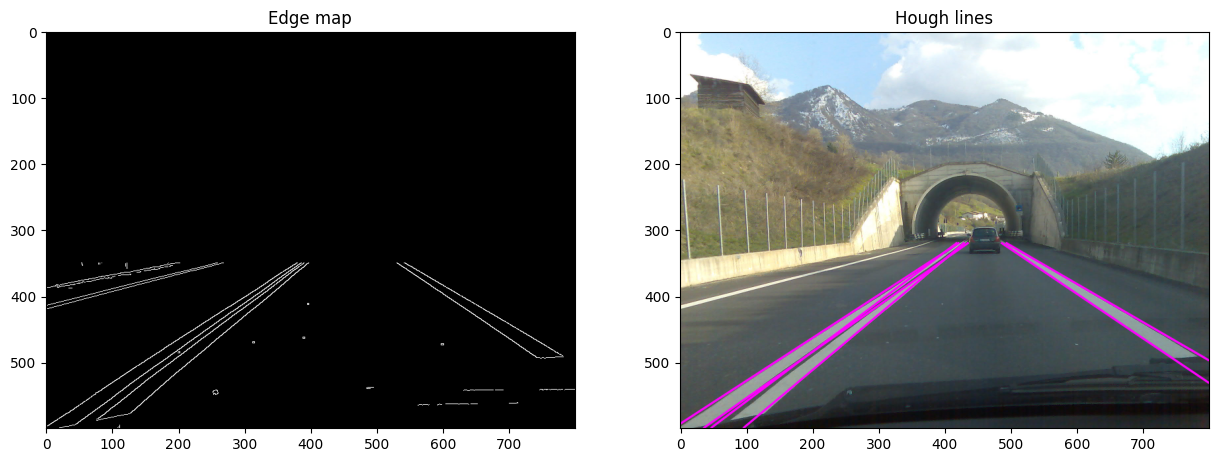

In [206]:
result = np.copy(img)

height, width, _ = img.shape
horizon_y = 320
roi_rect = (0, horizon_y, width, height - horizon_y)  # (x, y, w, h)

for rho, theta in kmeans.cluster_centers_:
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))

    ok, clipped_pt1, clipped_pt2 = cv2.clipLine(roi_rect, pt1, pt2)
    if ok:
        cv2.line(result, clipped_pt1, clipped_pt2, (255, 0, 255), 2, cv2.LINE_AA)


plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

## Processing a Second Image with ROI and Line Classification

For the second image, the pipeline is extended and refined.
A trapezoidal Region of Interest (ROI) is introduced to focus the detection on the road surface. This reduces noise and improves line detection stability.

Additionally, the Probabilistic Hough Transform is applied to detect line segments instead of infinite lines. Duplicate detections are filtered out, and the detected segments are classified based on their length:

- Short segments correspond to dashed lane markings

- Long segments correspond to solid lane markings

- The results are visualized using color coding.

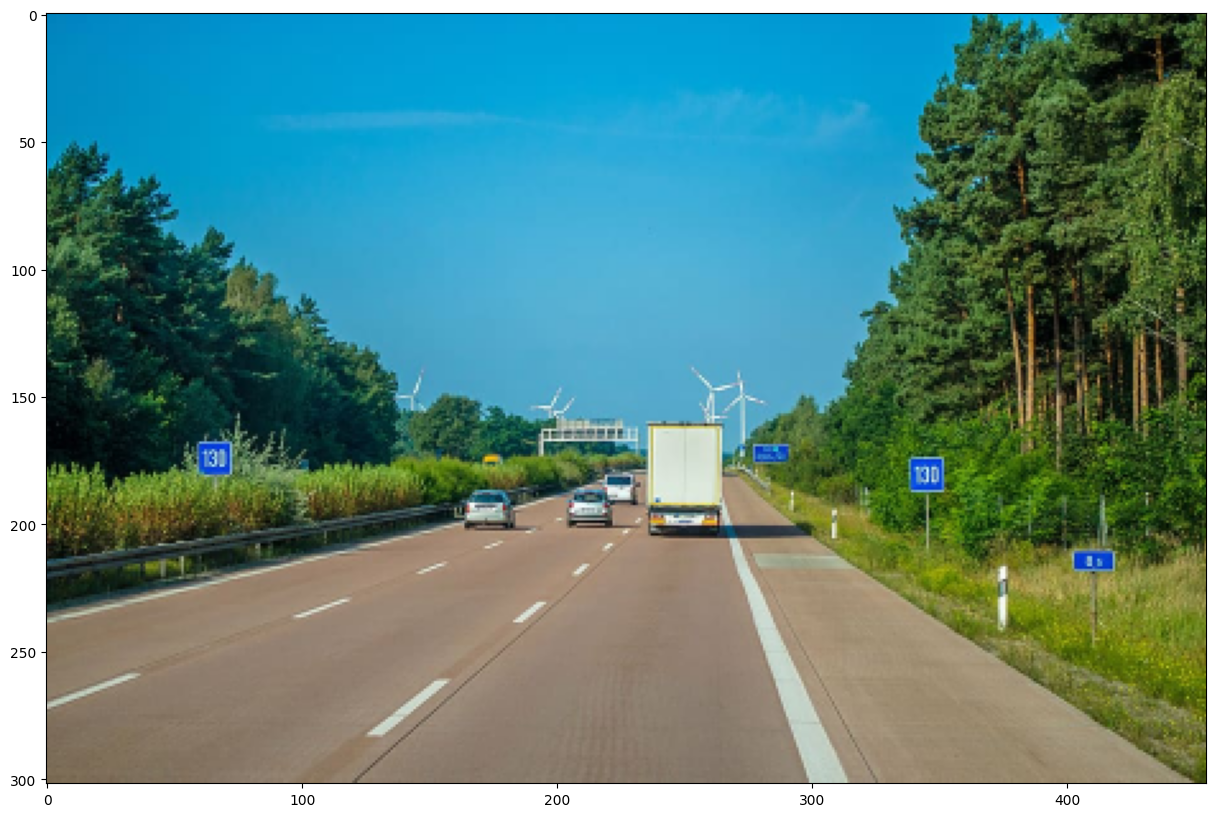

In [207]:
img2 = cv2.imread('data/motorway-poland-track-road.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2, None, fx=0.5, fy=0.5)
plt.imshow(img2)

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

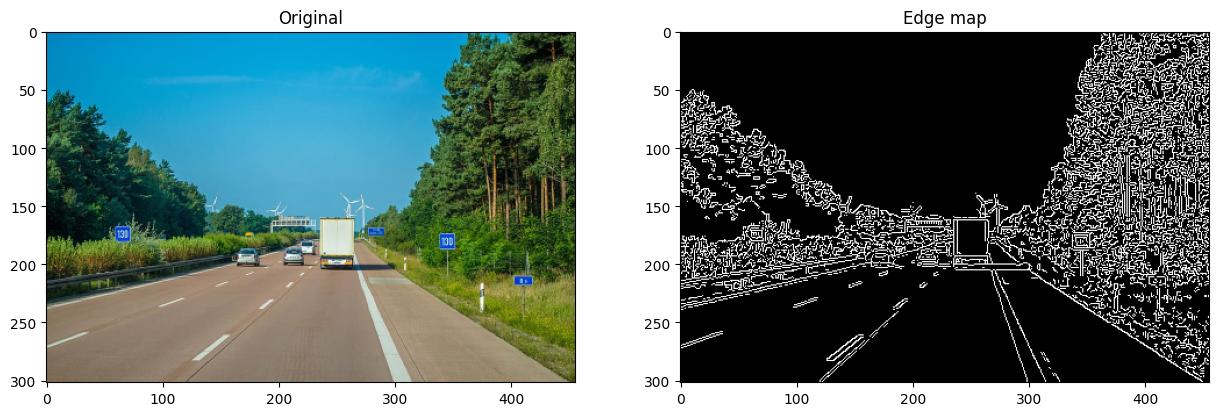

In [215]:
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
edges2 =cv2.Canny(gray2, 100, 150)
plt.subplot(121), plt.imshow(img2), plt.title('Original')
plt.subplot(122), plt.imshow(edges2, cmap='gray'), plt.title('Edge map')

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

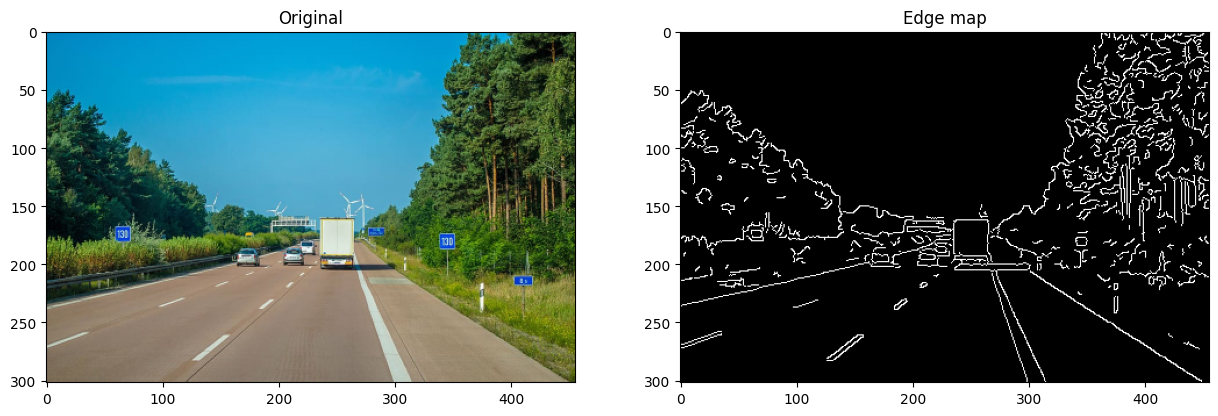

In [216]:
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray2, (5, 5), 0)
edges2 =cv2.Canny(blur, 100, 150)
plt.subplot(121), plt.imshow(img2), plt.title('Original')
plt.subplot(122), plt.imshow(edges2, cmap='gray'), plt.title('Edge map')

In [217]:
# define the working area
h, w = edges2.shape
mask = np.zeros_like(edges2)

polygon = np.array([[
    (int(-0.18*w), h),
    (int(0.42*w), int(0.68*h)), 
    (int(0.60*w), int(0.68*h)),
    (int(0.90*w), h)
]], dtype=np.int32)


cv2.fillPoly(mask, polygon, 255)
edges_roi = cv2.bitwise_and(edges2, mask)

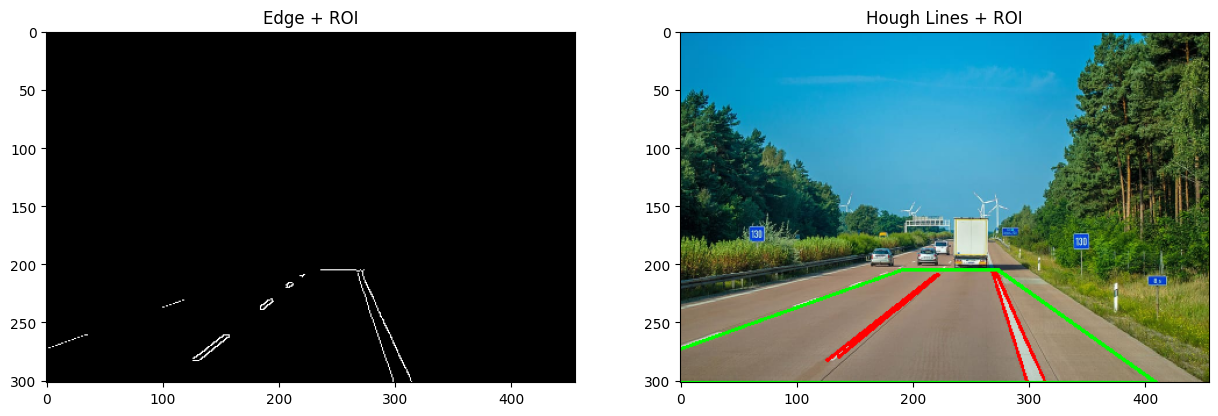

In [218]:
lines2 = cv2.HoughLinesP(
    edges_roi,
    rho=2,
    theta=np.deg2rad(2),
    threshold=40,
    minLineLength=25,
    maxLineGap=60
)

result2 = img2.copy()

if lines2 is not None:
    for line in lines2:
        x1, y1, x2, y2 = line[0]
        cv2.line(result2, (x1,y1), (x2,y2), (255,0,0), 2)

cv2.polylines(result2, [polygon], True, (0,255,0), 2)

plt.subplot(121)
plt.imshow(edges_roi, cmap='gray')
plt.title("Edge + ROI")

plt.subplot(122)
plt.imshow(result2)
plt.title("Hough Lines + ROI")

plt.show()

0: len=103.0, angle=65.9
1: len=99.6, angle=72.5
2: len=44.2, angle=-37.6
3: len=32.8, angle=-37.6


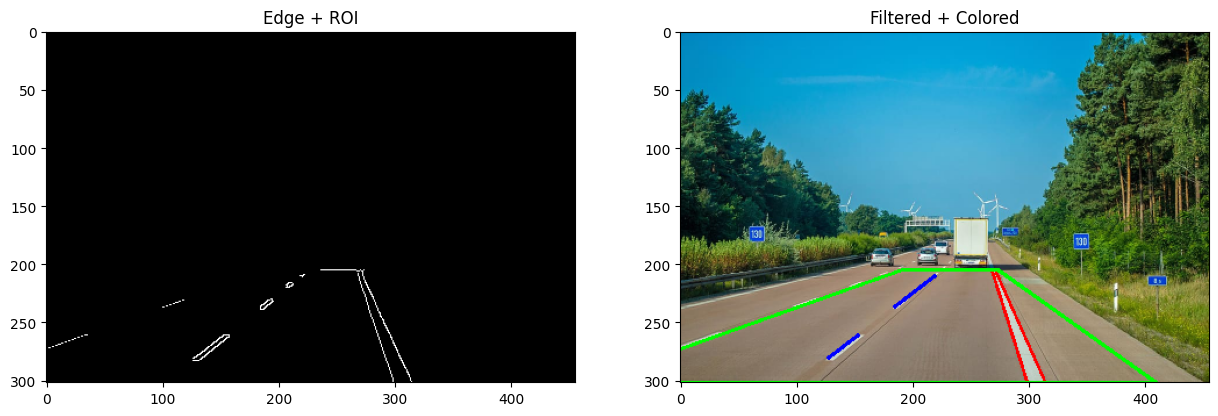

In [219]:
lines2 = cv2.HoughLinesP(
    edges_roi,
    rho=2,
    theta=np.deg2rad(2),
    threshold=40,
    minLineLength=25,
    maxLineGap=12
)

result2 = img2.copy()

unique = []

if lines2 is not None:

    lines_sorted = sorted(
        lines2,
        key=lambda l: np.hypot(l[0][2]-l[0][0], l[0][3]-l[0][1]),
        reverse=True
    )

    for line in lines_sorted:
        x1, y1, x2, y2 = line[0]

        length = np.hypot(x2-x1, y2-y1)
        angle = np.rad2deg(np.arctan2(y2-y1, x2-x1))

        cx = (x1 + x2) / 2

        duplicate = False

        for ucx, uang, *_ in unique:
            if abs(angle - uang) < 4 and abs(cx - ucx) < 12:
                duplicate = True
                break

        if not duplicate:
            unique.append((cx, angle, x1, y1, x2, y2, length))

for i, (cx, angle, x1, y1, x2, y2, length) in enumerate(unique):
    print(f"{i}: len={length:.1f}, angle={angle:.1f}")

for cx, angle, x1, y1, x2, y2, length in unique:

    if length < 60:
        color = (0,0,255)
    else:
        color = (255,0,0)

    cv2.line(result2, (x1,y1), (x2,y2), color, 2)


cv2.polylines(result2, [polygon], True, (0,255,0), 2)

plt.subplot(121)
plt.imshow(edges_roi, cmap='gray')
plt.title("Edge + ROI")

plt.subplot(122)
plt.imshow(result2)
plt.title("Filtered + Colored")

plt.show()


## Questions

### 1. Do you see anything strange in the final result?

Yes, several observations can be made regarding the final result.

Before applying the region-of-interest (ROI) clipping and clustering, the detected Hough lines tend to intersect at a common point near the center of the image. This happens because the standard Hough Transform detects infinite lines in the image space. As a result, their visual representation often creates artificial intersections that do not correspond to real physical intersections in the scene.

Another noticeable aspect is that multiple very similar lines are detected for each lane marking. This occurs because many edge pixels vote for nearby parameter values in the Hough accumulator. Instead of producing a single clean detection per lane, the transform generates clusters of similar lines in the parameter space.

After applying ROI clipping and k-means clustering, the result becomes significantly cleaner and better aligned with the actual lane boundaries. However, the need for clustering highlights a limitation of the raw Hough transform output: it does not inherently enforce uniqueness or geometric consistency of detected lines.

---

### 2. Do you think the Hough transform resolution is important for obtaining a good result? Why?

Yes, the resolution of the Hough transform is highly important.

The resolution defines the discretization step for both ρ (distance from origin) and θ (angle). If the resolution is too coarse, different physical lines may fall into the same accumulator bin, reducing geometric precision and causing inaccurate detections.

Conversely, if the resolution is too fine, the parameter space becomes very large. In that case, votes from edge pixels may spread across neighboring bins, resulting in fragmented detections and increased sensitivity to noise. This also increases computational cost.

Therefore, selecting an appropriate resolution (e.g., 2 pixels for ρ and 2 degrees for θ in this implementation) provides a good trade-off between geometric accuracy, robustness, and computational efficiency.

---

### 3. Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?

Yes, the accumulator threshold is a critical parameter.

The threshold determines the minimum number of votes required for a line to be accepted as a valid detection. If the threshold is set too low, even weak or noisy edge structures may accumulate enough votes to be detected, resulting in many spurious lines and a cluttered output.

If the threshold is set too high, valid lane markings may fail to accumulate sufficient votes, especially in cases of partial occlusion, faded markings, or fragmented edges. This would lead to missing detections.

Thus, the accumulator threshold directly controls the balance between sensitivity and robustness. In this implementation, a threshold of 190 was found to provide a reasonable balance, allowing strong lane markings to be detected while suppressing most noise.
